# 03 Working With Maps


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from pyproj import CRS
from geopy.geocoders import Nominatim
from utils.helper_functions import add_area_and_label_coords, plot_with_labels, calc_overall_centroid, haversine_np
import os

# file path constants
PATH_TO_SNOWSTORM_DATA = "../data/snowstorm_PA.tsv"
PATH_TO_PA_CITIES_COUNTIES_DATA = "../data/PA_cities_counties.tsv"
PATH_TO_PA_MUNI_DATA = "../data/PaMunicipalities2022_01.zip"
PATH_TO_TL_COUNTY_DATA = "../data/tl_2021_us_county.zip"

PATH_TO_PICKLE_COUNTIES_FILE = "../data/counties_snow.pkl"

# read in data
snowstorm_df = pd.read_csv(PATH_TO_SNOWSTORM_DATA, sep="\t")
pa_cities_counties_df = pd.read_csv(PATH_TO_PA_CITIES_COUNTIES_DATA, sep="\t")
pa_muni_gpd = gpd.read_file(PATH_TO_PA_MUNI_DATA)
tl_us_county_gpd = gpd.read_file(PATH_TO_TL_COUNTY_DATA)

c:\Users\erick\Documents\gradschool\cmu\spring-2025\info-visualization-mini-i\information-visualization-class\assignments\03_working_with_maps\src\utils\helper_functions.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  some_gdf['area'] = some_gdf.area
c:\Users\erick\Documents\gradschool\cmu\spring-2025\info-visualization-mini-i\information-visualization-class\assignments\03_working_with_maps\.venv\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\erick\Documents\gradschool\cmu\spring-2025\info-visualization-mini-i\informati

Text(0.5, 0.98, 'Ortho')

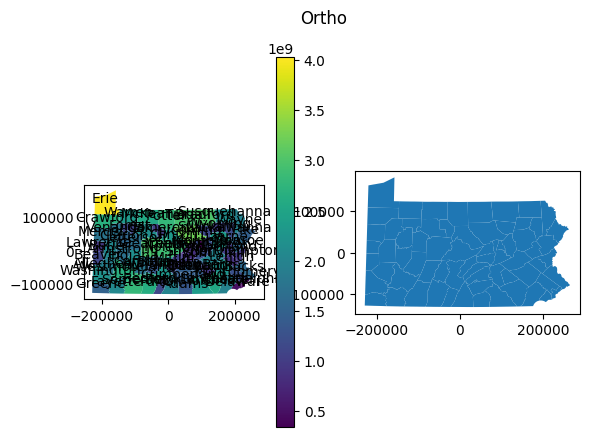

In [2]:
# select geometry for PA from GeoDF PA FIPS = 42
pa_geom = tl_us_county_gpd[tl_us_county_gpd["STATEFP"] == "42"]

# set up orthographic projection
add_area_and_label_coords(pa_geom)
centroid_x, centroid_y = calc_overall_centroid(pa_geom)

lat = centroid_y
lon = centroid_x
ortho = CRS.from_proj4(
    f"+proj=ortho +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0 +a=6370997 +b=6370997 +units=m +no_defs")

ortho_gdf = pa_geom.to_crs(ortho)
ortho_gdf.crs

add_area_and_label_coords(ortho_gdf)
fig, axes = plt.subplots(1, 2)
plot_with_labels(ortho_gdf, field_col='area', name_col='NAME', ax=axes[0])
plot_with_labels(ortho_gdf, ax=axes[1])
fig.suptitle('Ortho')

In [ ]:
# Estimate county wide snowfall numbers
snowstorm_counties_df = pd.merge(
    left=snowstorm_df,
    right=pa_cities_counties_df,
    left_on="Location",
    right_on="Name",
    how="left",
)

# Geolocator times out with too many requests. If available, load the pickle
# file and skip the request
if os.path.exists(PATH_TO_PICKLE_COUNTIES_FILE):
    snowstorm_counties_df = pd.read_pickle(PATH_TO_PICKLE_COUNTIES_FILE)
else:
    # use Nomanatim to get missing county values
    locations = []
    missing_indecies = []
    geolocator = Nominatim(user_agent="edcmsdas")
    for index, row in snowstorm_counties_df.iterrows():
        # missing Counties as nan floats here
        if type(row["County"]) is float:
            # geolocate
            gl = geolocator.geocode(f"{row["Location"]} Pennsylvania US")

            # convert the location to string and save. will split to retrieve the county after
            gl_str = str(gl)

            # fill in county for the missing row
            snowstorm_counties_df.at[index, "County"] = gl_str

            # track missing index
            missing_indecies.append(index)

    # Save the dataframe as a pickle file
    snowstorm_counties_df.to_pickle(PATH_TO_PICKLE_COUNTIES_FILE)

In [ ]:
# fix the missing indecies split string
for index in missing_indecies:
    print(snowstorm_counties_df.iloc[index, "County"])

#
# # # get the second item (county) and remove the word "County" and any whitespace on the ends
# try:
#     county = gl_split[1].removesuffix("County").strip()

# except:
#     print(gl_split)
#     county = np.nan

In [46]:
len(set(snowstorm_counties_df.County))

31

In [4]:
# Prune df to only columns needed
cols_to_keep = ["County", "Expected Snowfall"]
snowstorm_counties_pruned_df = snowstorm_counties_df.loc[:, cols_to_keep]

# get the mean snowfall for each county
snowstorm_county_means = snowstorm_counties_pruned_df.groupby(["County"])[
    "Expected Snowfall"].mean().to_frame().reset_index(drop=False).rename(
        columns={"Expected Snowfall": "mean_expected_snowfall"})

In [42]:
# Merge snowfall df into GeoDataframe
gdf_snowstorm = pd.merge(
    left=snowstorm_county_means,
    right=ortho_gdf,
    left_on="County",
    right_on="NAME",
    how="right",
)

# make back into geodf
gdf_snowstorm = gpd.GeoDataFrame(gdf_snowstorm, geometry='geometry')

gdf_snowstorm.shape

(67, 22)

<Axes: >

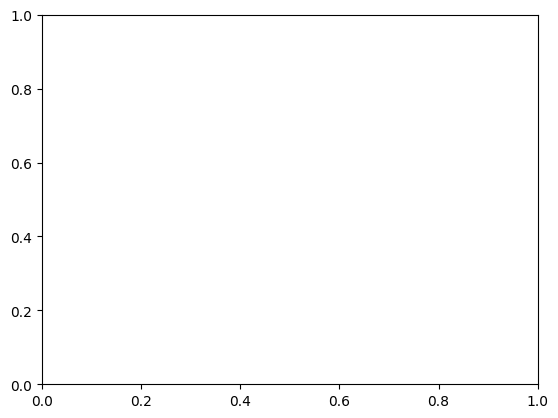

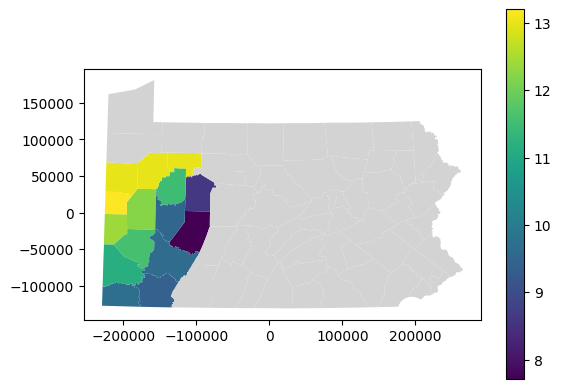

In [43]:
fig, ax = plt.subplots(1, 1)

gdf_snowstorm.plot(
    column="mean_expected_snowfall",
    legend=True,
    missing_kwds={'color': 'lightgrey'}
)

# plot_with_labels(gdf_snowstorm, field_col='mean_expected_snowfall',
#                  name_col='NAME', ax=ax, missing_kwds={'color': 'lightgrey'})